In [1]:
! pip install -q kagglehub

In [2]:
from google.colab import files
import os
import kagglehub

# Step 1: Upload kaggle.json manually
print("📂 Please upload your kaggle.json file:")
uploaded = files.upload()

# Ensure the uploaded file exists
if "kaggle.json" not in uploaded:
    print("❌ kaggle.json upload failed. Please try again.")
else:
    # Step 2: Move the file to the correct location
    !mkdir -p /root/.config/kaggle
    !mv kaggle.json /root/.config/kaggle/

    # Step 3: Set proper permissions (read and write)
    !chmod 600 /root/.config/kaggle/kaggle.json

    # Step 4: Verify that the file exists
    if os.path.exists("/root/.config/kaggle/kaggle.json"):
        print("✅ kaggle.json uploaded and set up correctly!")
    else:
        print("❌ kaggle.json upload failed. Please check the file path.")

# Step 5: download dataset
try:
    dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
    print("✅ Dataset downloaded successfully!")
    print("📂 Path to dataset files:", dataset_path)

    # Step 7: Move dataset to /content/{dataset-name} for easier access
    target_path = os.path.join(os.getcwd(), "intel_dataset")
    !mkdir -p {target_path}  # Ensure target directory exists
    !cp -r {dataset_path}/* {target_path}/

    print(f"✅ Dataset moved to {target_path}")
    print("📂 Final Dataset contents:", os.listdir(target_path))

except Exception as e:
    print("❌ Error downloading dataset:", e)

📂 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✅ kaggle.json uploaded and set up correctly!
Using Colab cache for faster access to the 'intel-image-classification' dataset.
✅ Dataset downloaded successfully!
📂 Path to dataset files: /kaggle/input/intel-image-classification
✅ Dataset moved to /content/intel_dataset
📂 Final Dataset contents: ['seg_test', 'seg_train', 'seg_pred']


In [3]:
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

In [4]:
#Explore data

In [5]:
train_folder_path = '/content/intel_dataset/seg_train/seg_train'
test_folder_path = '/content/intel_dataset/seg_test/seg_test'
pred_folder_path = '/content/intel_dataset/seg_pred/seg_pred'

In [6]:
os.listdir(train_folder_path)

['mountain', 'glacier', 'sea', 'buildings', 'street', 'forest']

In [7]:
for folder in os.listdir(train_folder_path):
  images = glob.glob(pathname=str(train_folder_path+'/'+folder+'/*.jpg'))
  print(f'For the folder {folder} we have {len(images)} images')

For the folder mountain we have 2512 images
For the folder glacier we have 2404 images
For the folder sea we have 2274 images
For the folder buildings we have 2191 images
For the folder street we have 2382 images
For the folder forest we have 2271 images


In [8]:
for folder in os.listdir(test_folder_path):
  images = glob.glob(pathname=str(test_folder_path+'/'+folder+'/*.jpg'))
  print(f'For the folder {folder} we have {len(images)} images')

For the folder mountain we have 525 images
For the folder glacier we have 553 images
For the folder sea we have 510 images
For the folder buildings we have 437 images
For the folder street we have 501 images
For the folder forest we have 474 images


In [9]:
sizes = []

for folder in os.listdir(train_folder_path):
  images = glob.glob(pathname=str(train_folder_path+'/'+folder+'/*.jpg'))
  for image in images:
    image = plt.imread(image)
    sizes.append(image.shape)

pd.Series(sizes).value_counts().head()

,count
"(150, 150, 3)",13986
"(113, 150, 3)",7
"(135, 150, 3)",3
"(111, 150, 3)",3
"(144, 150, 3)",2


array([[[ 30,  33,  14],
        [ 24,  27,  10],
        [ 35,  37,  24],
        ...,
        [140, 162,  97],
        [115, 139,  81],
        [ 80, 103,  47]],

       [[ 16,  19,   0],
        [ 27,  30,  13],
        [ 35,  37,  24],
        ...,
        [ 93, 115,  51],
        [182, 203, 146],
        [188, 208, 155]],

       [[ 24,  27,   8],
        [ 49,  52,  35],
        [ 23,  25,  11],
        ...,
        [105, 123,  63],
        [152, 169, 117],
        [134, 152, 104]],

       ...,

       [[ 62,  53,  36],
        [  9,   3,   0],
        [ 75,  72,  39],
        ...,
        [ 65,  94,  28],
        [ 40,  66,   3],
        [ 76, 105,  41]],

       [[111, 104,  85],
        [107, 103,  74],
        [ 96,  95,  51],
        ...,
        [106, 134,  59],
        [ 65,  91,  20],
        [103, 130,  61]],

       [[118, 113,  91],
        [107, 104,  73],
        [110, 112,  62],
        ...,
        [141, 168,  87],
        [ 64,  90,  17],
        [ 57,  83,  12]]], dtype=uint8)
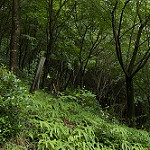

In [10]:
plt.imread("/content/intel_dataset/seg_train/seg_train/forest/10007.jpg")

In [11]:
# Model building

In [12]:
# generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)

#
train_gen = datagen.flow_from_directory(directory=train_folder_path,
                                        target_size = (100,100),
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        shuffle = True,
                                        )

test_gen = datagen.flow_from_directory(directory = test_folder_path , target_size=(100,100),batch_size = 32 , class_mode = 'categorical',shuffle = False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(100,100,3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation=None,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation=None,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation=None,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation=None,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation=None,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units = 6 , activation = 'softmax')

])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 572,614 (2.18 MB)

 Trainable params: 571,142 (2.18 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    callbacks=[earlystop]
)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9158 - loss: 0.2525 - val_accuracy: 0.8853 - val_loss: 0.3155
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9197 - loss: 0.2424 - val_accuracy: 0.8983 - val_loss: 0.3014
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9200 - loss: 0.2376 - val_accuracy: 0.8923 - val_loss: 0.3021
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9212 - loss: 0.2321 - val_accuracy: 0.8920 - val_loss: 0.3099
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9204 - loss: 0.2281 - val_accuracy: 0.8907 - val_loss: 0.3074
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.9241 - loss: 0.2206 - val_accuracy: 0.8927 - val_loss: 0.2963
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9248 - loss: 0.2183 - val_accuracy: 0.8947 - val_loss: 0.2955
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9237 - loss: 0.2196 - 

Text(0, 0.5, 'Accuracy')

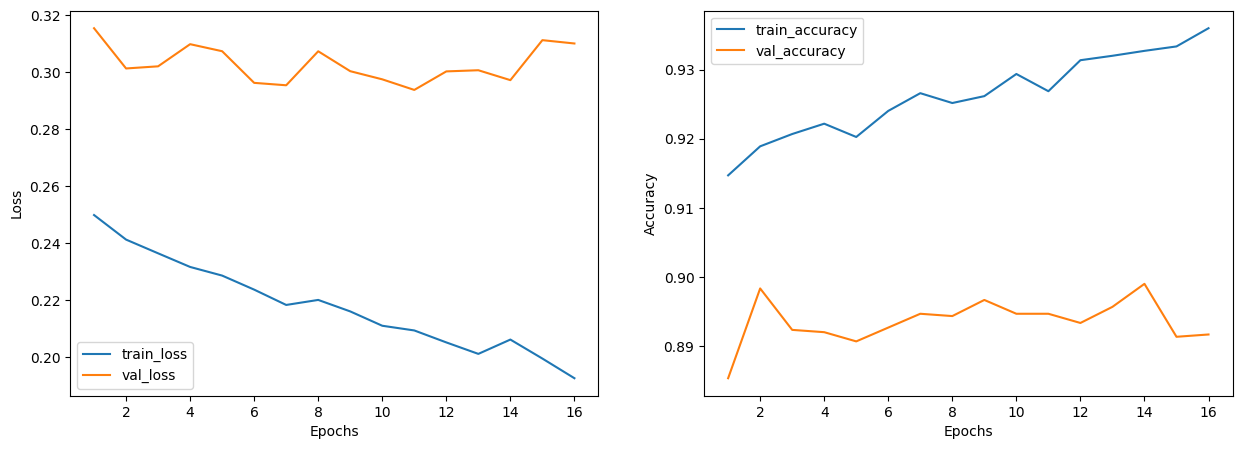

In [18]:

fig , axs = plt.subplots(1,2,figsize=(15,5))
epochs = len(history.history['loss'])
plt.sca(axs[0])
axs[0].plot(range(1,epochs+1),history.history['loss'],label='train_loss')
axs[0].plot(range(1,epochs+1),history.history['val_loss'],label='val_loss')
axs[0].legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.sca(axs[1])
axs[1].plot(range(1,epochs+1),history.history['accuracy'],label='train_accuracy')
axs[1].plot(range(1,epochs+1),history.history['val_accuracy'],label='val_accuracy')
axs[1].legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [19]:
loss_test , acc_test = model.evaluate(test_gen)
print(loss_test)
print(acc_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8867 - loss: 0.3183
0.2938213646411896
0.8946666717529297


In [20]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,input_shape=(100,100,3))
base_model.summary()

/tmp/ipython-input-168528366.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False,input_shape=(100,100,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 50, 50,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 50, 50,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 50, 50,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 50, 50,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 50, 50,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 50, 50,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 51, 51,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 25, 25,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 25, 25,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [21]:
base_model.trainable = False

In [22]:
base_model.trainable

False

In [24]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_gen = datagen.flow_from_directory(directory=train_folder_path,
                                        target_size = (100,100),
                                        batch_size = 32 ,
                                        shuffle = True ,
                                        class_mode = 'categorical')
test_gen = datagen.flow_from_directory(directory = test_folder_path , target_size=(100,100),batch_size = 32 , class_mode = 'categorical',shuffle = False)

#

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [26]:
model_finetune  = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128,activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6,activation = 'softmax')
])
model_finetune.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
model_finetune.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

earlystop = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
history = model_finetune.fit(train_gen , validation_data=test_gen ,
                             epochs = 20 ,
                             callbacks = earlystop)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8913 - loss: 0.2935

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - accuracy: 0.8913 - loss: 0.2935 - val_accuracy: 0.8837 - val_loss: 0.3172
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8995 - loss: 0.2732 - val_accuracy: 0.8900 - val_loss: 0.3089
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9027 - loss: 0.2614 - val_accuracy: 0.8893 - val_loss: 0.3079
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9083 - loss: 0.2538 - val_accuracy: 0.8917 - val_loss: 0.3075
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9211 - loss: 0.2310 - val_accuracy: 0.8893 - val_loss: 0.3071
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9268 - loss: 0.2080 - val_accuracy: 0.8917 - val_loss: 0.3042
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9283 - loss: 0.2044 - val_accuracy: 0.8890 - val_loss: 0.3055
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9305 - loss: 0.2008 - val_accurac

In [33]:
assets_folderpath = os.path.join(os.getcwd(),"assets")
os.makedirs(assets_folderpath,exist_ok=True)


In [34]:
model_finetune.save(filepath=os.path.join(assets_folderpath,"model.keras"))

idx_label  ={v:k for k,v in train_gen.class_indices.items()}
joblib.dump(idx_label,os.path.join(assets_folderpath,"idx2label.joblib"))

['/content/assets/idx2label.joblib']

In [35]:
images_paths = glob.glob(pathname=os.path.join(pred_folder_path,"*.jpg"))[:10]

In [44]:
def preprocess_image(image_path):

  image = tf.keras.preprocessing.image.load_img(image_path,target_size=(100,100))

  image = tf.keras.preprocessing.image.img_to_array(image)
  image = tf.expand_dims(image,axis=0)
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  return image


images = np.vstack([preprocess_image(image_path) for image_path in images_paths])
images.shape

(10, 100, 100, 3)

In [45]:
prediction_scores = model_finetune.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [46]:
prediction_scores.shape

(10, 6)

In [47]:
prediction_scores = np.argmax(prediction_scores,axis=-1)
prediction_scores

array([5, 4, 2, 2, 2, 5, 1, 3, 2, 2])

In [52]:
predictions = [idx_label[i] for i in prediction_scores]

In [53]:
predictions

['street',
 'sea',
 'glacier',
 'glacier',
 'glacier',
 'street',
 'forest',
 'mountain',
 'glacier',
 'glacier']

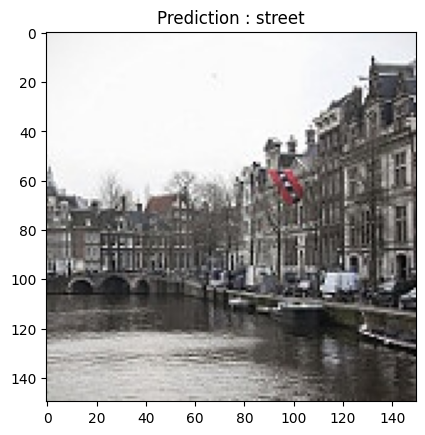

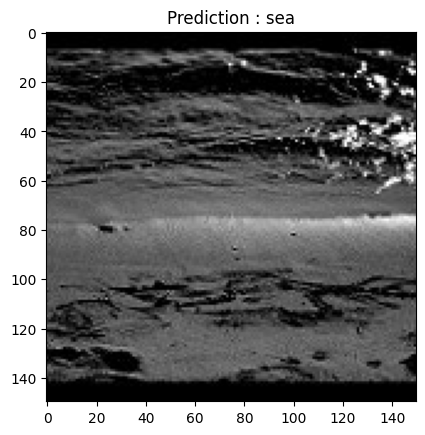

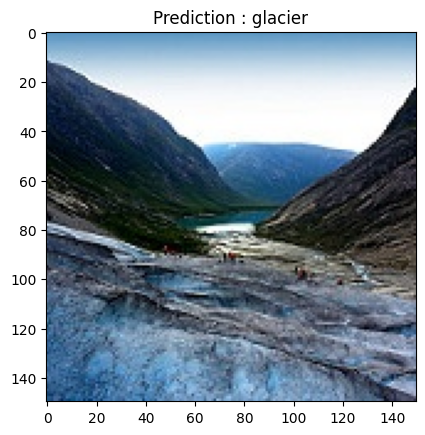

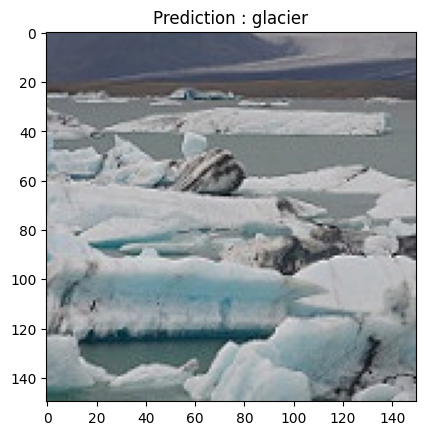

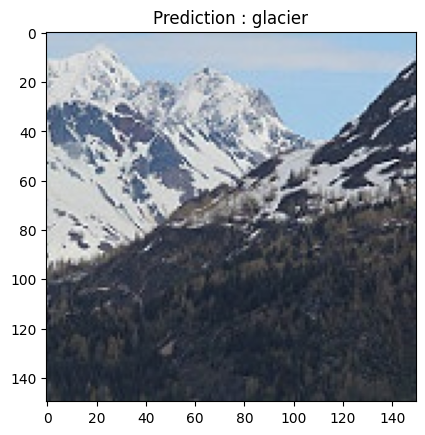

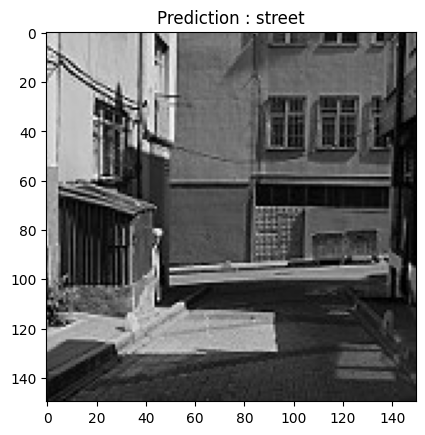

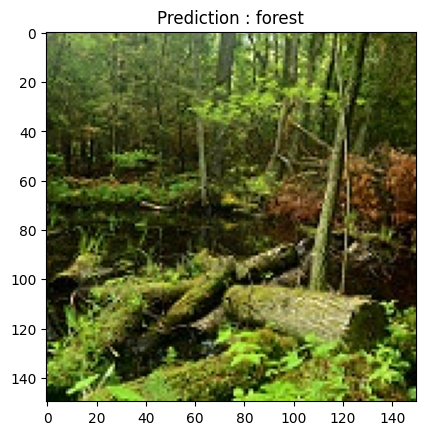

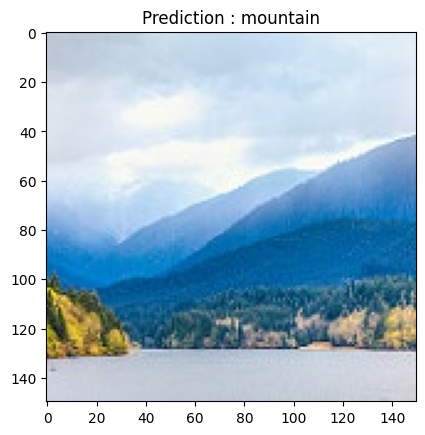

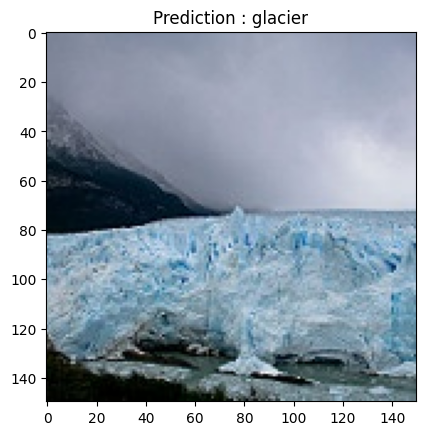

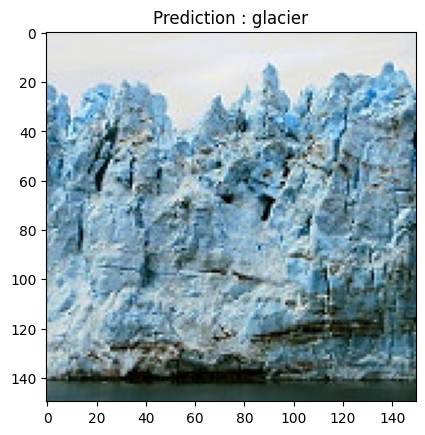

In [57]:
for i,image_path in enumerate(images_paths):
  image = plt.imread(image_path)
  plt.imshow(image)
  plt.title(f'Prediction : {predictions[i]}')
  plt.show()